<a href="https://colab.research.google.com/github/ricardordb/deep/blob/master/timassuntos_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Files
Please upload train data and Word2Vec model


In [0]:
import nltk
nltk.download('stopwords')


from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
import nltk
nltk.download('stopwords')

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Classify Training

In [0]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout, Concatenate, Activation
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, Adamax, Nadam
from sklearn.metrics import roc_auc_score, confusion_matrix

import keras.backend as K
if len(K.tensorflow_backend._get_available_gpus()) > 0:
  from keras.layers import CuDNNLSTM as LSTM
  from keras.layers import CuDNNGRU as GRU

from gensim.models import Word2Vec
from nltk.corpus import stopwords
from unicodedata import normalize as normtext
from string import punctuation
from joblib import dump


datapath = '/content/gdrive/My Drive/Colab Notebooks/data/'

trantab_all = str.maketrans(punctuation, len(punctuation)*" ")

cachedStopWords = list(map(lambda x : normtext('NFKD', x).encode('ASCII', 'ignore').decode('ASCII').lower(),
                           stopwords.words("portuguese")))


def pp_texto_resultado(text):
    if text is not None:
        # minusculos e tira acentuacao
        text = normtext('NFKD', text).encode('ASCII', 'ignore').decode('ASCII').lower()
        text = text.translate(trantab_all) #tira pontuacao
        text = re.sub(r'\d{5,}', '', str(text).strip()) # Retira todo número maior que 5 algarismos
        text = remove_stop(text) # retira stopwords
    else:
        return ''
    return text

def remove_stop(text):
    return ' '.join([word for word in text.split() if word not in cachedStopWords])


def preprocess(texts, tokenizer, maxlen=500):
  texts = map(pp_texto_resultado, texts)
  texts = tokenizer.texts_to_sequences(texts)
  return pad_sequences(texts, maxlen=maxlen)
  

def create_embedding_layer():
  # load pre-trained word embeddings into an Embedding layer
  # note that we set trainable = False so as to keep the embeddings fixed
  return Embedding(
            MAX_VOCAB_SIZE,
            EMBEDDING_DIM,
            weights=[embedding_matrix],
            input_length=MAX_SEQUENCE_LENGTH,
            trainable=False
          )

def rnn():
    embedding_layer = create_embedding_layer()
    input_1 = Input(shape=(MAX_SEQUENCE_LENGTH,), name='Texto')
    input_2 = Input(shape=(MAX_SEQUENCE_LENGTH,), name='Assunto')
    x1 = embedding_layer(input_1)
    x2 = embedding_layer(input_2)
    x = Concatenate()([x1, x2])
    #x = GRU(128, return_sequences=True)(x)
    #x = LSTM(128, return_sequences=True)(x)
#     x = Dropout(0.2)(x)    
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
#     x = Bidirectional(LSTM(128, return_sequences=True))(x)
#     x = Dropout(0.2)(x)
    x = GlobalMaxPool1D()(x)
    output = Dense(1, activation="sigmoid")(x)
    model = Model([input_1, input_2], output)
    model.compile(
            loss='binary_crossentropy',
            optimizer=Nadam(lr=0.01),
            metrics=['accuracy']
          )
    return model
  

# some configuration
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 40
MAX_SEQUENCE_LENGTH = 500


word_vectors = Word2Vec.load(datapath + "w2v_trabalhista.model")
EMBEDDING_DIM = word_vectors.vector_size
MAX_VOCAB_SIZE = len(word_vectors.wv.index2word) + 1
print('Found %s by %s word vectors.' % (MAX_VOCAB_SIZE, EMBEDDING_DIM))


# prepare text samples and their labels
print('Loading in comments...')

train = pd.read_excel(datapath + "train_sentiment.xlsx", usecols=['texto', 'assunto', 'classify']).dropna()
texto = train['texto'].apply(pp_texto_resultado)
assunto = train['assunto'].apply(pp_texto_resultado)
#Loss: binary_crossentropy Activation: sigmoid
targets = train["classify"]
#Loss: hinge   Activation: tanh
#targets = train["Sentiment"].values 

# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(texto)
texto_seq = tokenizer.texts_to_sequences(texto)
assunto_seq = tokenizer.texts_to_sequences(assunto)


# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))


# pad sequences so that we get a N x T matrix
texto_data = pad_sequences(texto_seq, maxlen=MAX_SEQUENCE_LENGTH)
assunto_data = pad_sequences(assunto_seq, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensors:', (texto_data.shape, assunto_data.shape))



# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = MAX_VOCAB_SIZE
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
       # words not found in embedding index will be all zeros.
      try:
          embedding_vector = word_vectors.wv.get_vector(word)
          embedding_matrix[i] = embedding_vector
      except:
          pass



Using TensorFlow backend.
W0805 15:19:26.614912 140390381836160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0805 15:19:26.616068 140390381836160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0805 15:19:26.616883 140390381836160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0805 15:19:27.897845 140390381836160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

/usr/local/l

Found 11204 by 100 word vectors.
Loading in comments...
Found 95260 unique tokens.
Shape of data tensors: ((100814, 500), (100814, 500))
Filling pre-trained embeddings...


W0805 15:20:52.165421 140390381836160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



Building model...


W0805 15:20:55.796332 140390381836160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0805 15:20:55.807522 140390381836160 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Texto (InputLayer)              (None, 500)          0                                            
__________________________________________________________________________________________________
Assunto (InputLayer)            (None, 500)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 500, 100)     1120400     Texto[0][0]                      
                                                                 Assunto[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 500, 200)     0           embedding_1[0][0]                
          

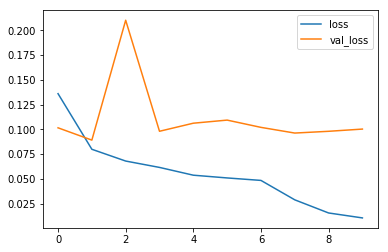

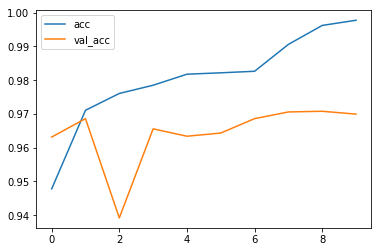

0.997143785300126
[[50732  1257]
 [  847 47978]]


['/content/gdrive/My Drive/Colab Notebooks/data/tokenizer.joblib.gz']

In [0]:

print('Building model...')

model = rnn()

model.summary()

es = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=8, verbose=2, restore_best_weights=True)
rop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=2)

print('Training model...')
r = model.fit(
  [texto_data, assunto_data],
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT,
  callbacks=[es, rop]
)

# plot some data
plt.rcParams["figure.figsize"] = (6,4)
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

p = model.predict([texto_data, assunto_data])
print(roc_auc_score(targets, p))
pc = np.round(p)
print(confusion_matrix(targets, pc))

#train['predictions'] = np.where(pc==0, -1, pc) 
#train['probs'] = p

model.save_weights(datapath + 'classify_trab_weights.h5')
dump(embedding_matrix, datapath + 'embedding_matrix.joblib.gz', compress='gzip')
dump(tokenizer, datapath + 'tokenizer.joblib.gz', compress='gzip')


# Sentiment Training

Found 11204 by 100 word vectors.
Loading in comments...
Found 95260 unique tokens.
Shape of data tensors: ((48825, 500), (48825, 500))
Building model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Texto (InputLayer)              (None, 500)          0                                            
__________________________________________________________________________________________________
Assunto (InputLayer)            (None, 500)          0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 500, 100)     1120400     Texto[0][0]                      
                                                                 Assunto[0][0]                    
_______________________________________________________

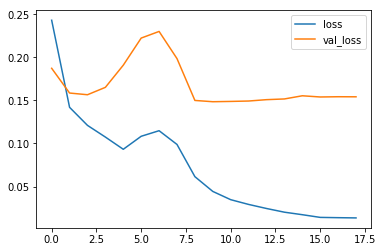

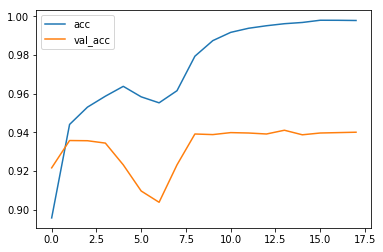

0.9975182413187096
[[30011   398]
 [  421 17995]]


In [0]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout, SpatialDropout1D, Concatenate, Activation
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, Adamax, Nadam
from sklearn.metrics import roc_auc_score, confusion_matrix

import keras.backend as K
if len(K.tensorflow_backend._get_available_gpus()) > 0:
  from keras.layers import CuDNNLSTM as LSTM
  from keras.layers import CuDNNGRU as GRU

from gensim.models import Word2Vec
from nltk.corpus import stopwords
from unicodedata import normalize as normtext
from string import punctuation
from joblib import dump, load


trantab_all = str.maketrans(punctuation, len(punctuation)*" ")

cachedStopWords = list(map(lambda x : normtext('NFKD', x).encode('ASCII', 'ignore').decode('ASCII').lower(),
                           stopwords.words("portuguese")))


def pp_texto_resultado(text):
    if text is not None:
        # minusculos e tira acentuacao
        text = normtext('NFKD', text).encode('ASCII', 'ignore').decode('ASCII').lower()
        text = text.translate(trantab_all) #tira pontuacao
        text = re.sub(r'\d{5,}', '', str(text).strip()) # Retira todo número maior que 5 algarismos
        text = remove_stop(text) # retira stopwords
    else:
        return ''
    return text

def remove_stop(text):
    return ' '.join([word for word in text.split() if word not in cachedStopWords])


def preprocess(texts, tokenizer, maxlen=500):
  texts = map(pp_texto_resultado, texts)
  texts = tokenizer.texts_to_sequences(texts)
  return pad_sequences(texts, maxlen=maxlen)


def rnn():
    embedding_layer = create_embedding_layer()
    input_1 = Input(shape=(MAX_SEQUENCE_LENGTH,), name='Texto')
    input_2 = Input(shape=(MAX_SEQUENCE_LENGTH,), name='Assunto')
    x1 = embedding_layer(input_1)
    x2 = embedding_layer(input_2)
    x = Concatenate()([x1, x2])
    #x = GRU(128, return_sequences=True)(x)
    #x = LSTM(128, return_sequences=True)(x)
#     x = Dropout(0.2)(x)
#     x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
#     x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.2)(x)
    x = GlobalMaxPool1D()(x)
    output = Dense(1, activation="sigmoid")(x)
    model = Model([input_1, input_2], output)
    model.compile(
            loss='binary_crossentropy',
            optimizer=Nadam(lr=0.01),
            metrics=['accuracy']
          )
    return model
  
  
# some configuration
MAX_SEQUENCE_LENGTH = 500
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 40

datapath = '/content/gdrive/My Drive/Colab Notebooks/data/'


embedding_matrix = load(datapath + 'embedding_matrix.joblib.gz')
EMBEDDING_DIM = embedding_matrix.shape[1]
MAX_VOCAB_SIZE = embedding_matrix.shape[0]
print('Found %s by %s word vectors.' % (MAX_VOCAB_SIZE, EMBEDDING_DIM))


# prepare text samples and their labels
print('Loading in comments...')

train = pd.read_excel(datapath + "train_sentiment.xlsx", usecols=['texto', 'classify', 'assunto', 'sentimentprob']).dropna()
train = train[train["classify"] == 1]
texto = train['texto'].apply(pp_texto_resultado)
assunto = train['assunto'].apply(pp_texto_resultado)
#Loss: binary_crossentropy Activation: sigmoid
#targets = train["sentimentprob"].replace(-1, 0).values
targets = train["sentimentprob"] > 0.5
#Loss: hinge   Activation: tanh
#targets = train["Sentiment"].values 

# convert the sentences (strings) into integers
tokenizer = load(datapath + 'tokenizer.joblib.gz')
texto_seq = tokenizer.texts_to_sequences(texto)
assunto_seq = tokenizer.texts_to_sequences(assunto)


# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))


# pad sequences so that we get a N x T matrix
texto_data = pad_sequences(texto_seq, maxlen=MAX_SEQUENCE_LENGTH)
assunto_data = pad_sequences(assunto_seq, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensors:', (texto_data.shape, assunto_data.shape))



# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = create_embedding_layer()

print('Building model...')

model = rnn()
model.summary()

es = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=8, verbose=1, restore_best_weights=True)
rop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)

print('Training model...')
r = model.fit(
  [texto_data, assunto_data],
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT,
  callbacks=[es, rop]
)

# plot some data
plt.rcParams["figure.figsize"] = (6,4)
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

p = model.predict([texto_data, assunto_data])
print(roc_auc_score(targets, p))
pc = np.round(p)
print(confusion_matrix(targets, pc))

#train['predictions'] = np.where(pc==0, -1, pc) 
#train['probs'] = p

model.save_weights(datapath + 'sentiment_trab_weights.h5')


# Result saving and downloading

In [0]:
from google.colab import files


#model.save(datapath + 'model_trabalhista.h5')


filenames = ['sentiment_trab_weights.h5', 'classify_trab_weights.h5', 'tokenizer.joblib.gz', 'embedding_matrix.joblib.gz']

for name in filenames:
  files.download(datapath + name)

In [0]:
datapath + name

'/content/gdrive/My Drive/Colab Notebooks/data/sentiment_trab_weights.h5'

# Model Visualization

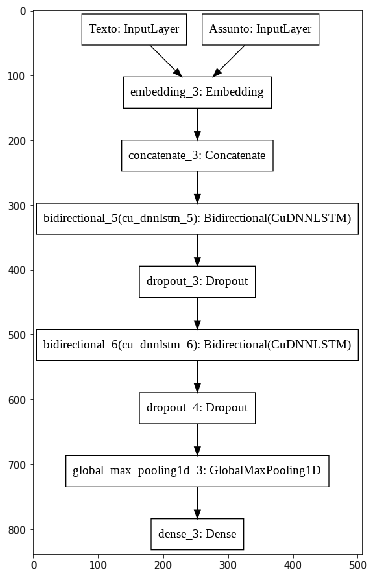

In [0]:
from keras.utils import plot_model
import matplotlib.pyplot as plt

# Plot the model
plot_model(model, to_file='model.png')

# Display the image
data = plt.imread('model.png')
plt.rcParams["figure.figsize"] = (20,10)
plt.imshow(data)
plt.show()

In [0]:
text = preprocess(['improcedeo pleito de aplicacao da multa prevista no artigo 477 da CLT, visto que as verbas rescisorias foram pagas no prazo previsto no mesmo artigo.'],
                  tokenizer, MAX_SEQUENCE_LENGTH)
ass = preprocess(['multa'], tokenizer, MAX_SEQUENCE_LENGTH)
model.predict([text, ass])

array([[0.5029173]], dtype=float32)

text.shape

In [0]:

def preprocess(texts, tokenizer, maxlen=500):
  texts = map(pp_texto_resultado, texts)
  texts = tokenizer.texts_to_sequences(texts)
  return pad_sequences(texts, maxlen=maxlen)

In [0]:
planilha = pd.read_excel(datapath + "decisoes_classificar.xlsx")
texto_data = preprocess(planilha['texto'].values, tokenizer)
assunto_data = preprocess(planilha['assunto'].values, tokenizer)


p = model.predict([texto_data, assunto_data])
pc = np.round(p)
planilha['predictions'] = np.where(pc==0, -1, pc) 
planilha['probs'] = p


In [0]:
p = model.predict([texto_data, assunto_data])
pc = np.round(p)
planilha['predictions'] = np.where(pc==0, -1, pc) 
planilha['probs'] = p

In [0]:
from joblib import dump
dump(embedding_matrix, datapath + 'sent_emb_matrix.joblib.gz', compress='gzip')

['/content/gdrive/My Drive/Colab Notebooks/data/sent_emb_matrix.joblib.gz']

In [0]:
planilha.to_excel(datapath + 'decisoes_classificadas.xlsx', encoding='utf8', index=False)

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.optimizers import SGD


def criarRede(optimizer, loss, activation, units, dropout):
    # create an LSTM network
    input_1 = Input(shape=(MAX_SEQUENCE_LENGTH,), name='Texto')
#     input_2 = Input(shape=(MAX_SEQUENCE_LENGTH,), name='Assunto')
    x = embedding_layer(input_1)
#     x2 = embedding_layer(input_2)
#     x = Concatenate()([x1, x2])
    x = Bidirectional(LSTM(units=units, return_sequences=True))(x)
    x = Dropout(dropout)(x)
    x = Bidirectional(LSTM(units=units, return_sequences=True))(x)
    x = Dropout(dropout)(x)
    x = GlobalMaxPool1D()(x)
    output = Dense(1, activation=activation)(x)
    model = Model(input_1, output)
    model.compile(
      loss=loss,
      optimizer=optimizer(lr=0.01),
      metrics=['accuracy']
    )
    return model
  
  


classificador = KerasClassifier(build_fn = criarRede)
parametros = {'batch_size': [128, 256],
              'epochs': [15],
              'optimizer': [Adam, Nadam],
              'loss': ['binary_crossentropy'],
              'activation': ['sigmoid'],
              'units': [100, 150],
              'dropout': [0.3, 0.5]              
             }
grid_search = GridSearchCV(estimator = classificador,
                           param_grid = parametros,
                           scoring = 'accuracy',
                           cv=3,
                           verbose=2)


es = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=8, verbose=1, restore_best_weights=True)
rop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)

print('Training model...')
grid_search = grid_search.fit(
  texto_data,
  targets,
  validation_split=VALIDATION_SPLIT,
  callbacks=[es, rop]
)

melhores_parametros = grid_search.best_params_
melhor_precisao = grid_search.best_score_

Training model...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] activation=sigmoid, batch_size=128, dropout=0.3, epochs=15, loss=binary_crossentropy, optimizer=<class 'keras.optimizers.Adam'>, units=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train on 2681 samples, validate on 671 samples
Epoch 1/15
2681/2681 [==============================] - 6s 2ms/step - loss: 0.6895 - acc: 0.6430 - val_loss: 0.4930 - val_acc: 0.7720
Epoch 2/15
2681/2681 [==============================] - 4s 1ms/step - loss: 0.3637 - acc: 0.8411 - val_loss: 0.3099 - val_acc: 0.8718
Epoch 3/15
2681/2681 [==============================] - 4s 1ms/step - loss: 0.1986 - acc: 0.9291 - val_loss: 0.2164 - val_acc: 0.9255
Epoch 4/15
2681/2681 [==============================] - 4s 1ms/step - loss: 0.1265 - acc: 0.9556 - val_loss: 0.2121 - val_acc: 0.9270
Epoch 5/15
2681/2681 [==============================] - 4s 1ms/step - loss: 0.1041 - acc: 0.9634 - val_loss: 0.1855 - val_acc: 0.9344
Epoch 6/15
2681/2681 [==============================] - 4s 1ms/step - loss: 0.0557 - acc: 0.9806 - val_loss: 0.1799 - val_acc: 0.9419
Epoch 7/15
2681/2681 [==============================] - 4s 1ms/step - loss: 0.0293 - acc: 0.9918 - val_loss: 0.1925 - val_acc: 0.9374
Epoch 8/15
2681

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


Train on 2681 samples, validate on 671 samples
Epoch 1/15
2681/2681 [==============================] - 7s 2ms/step - loss: 0.6401 - acc: 0.6662 - val_loss: 0.4605 - val_acc: 0.7630
Epoch 2/15
2681/2681 [==============================] - 4s 1ms/step - loss: 0.3505 - acc: 0.8497 - val_loss: 0.2887 - val_acc: 0.8808
Epoch 3/15
2681/2681 [==============================] - 4s 1ms/step - loss: 0.1955 - acc: 0.9179 - val_loss: 0.2624 - val_acc: 0.8972
Epoch 4/15
2681/2681 [==============================] - 4s 1ms/step - loss: 0.1205 - acc: 0.9556 - val_loss: 0.2412 - val_acc: 0.9136
Epoch 5/15
2681/2681 [==============================] - 4s 1ms/step - loss: 0.0787 - acc: 0.9724 - val_loss: 0.2265 - val_acc: 0.9285
Epoch 6/15
2681/2681 [==============================] - 4s 1ms/step - loss: 0.0586 - acc: 0.9787 - val_loss: 0.2053 - val_acc: 0.9285
Epoch 7/15
2681/2681 [==============================] - 4s 1ms/step - loss: 0.0360 - acc: 0.9892 - val_loss: 0.2193 - val_acc: 0.9314
Epoch 8/15
2681

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 69.5min finished


Train on 4022 samples, validate on 1006 samples
Epoch 1/15
4022/4022 [==============================] - 23s 6ms/step - loss: 0.6289 - acc: 0.6907 - val_loss: 0.5278 - val_acc: 0.7565
Epoch 2/15
4022/4022 [==============================] - 6s 1ms/step - loss: 0.3173 - acc: 0.8707 - val_loss: 0.3468 - val_acc: 0.8539
Epoch 3/15
4022/4022 [==============================] - 6s 1ms/step - loss: 0.1712 - acc: 0.9339 - val_loss: 0.2637 - val_acc: 0.9085
Epoch 4/15
4022/4022 [==============================] - 6s 1ms/step - loss: 0.1009 - acc: 0.9615 - val_loss: 0.2605 - val_acc: 0.8966
Epoch 5/15
4022/4022 [==============================] - 6s 1ms/step - loss: 0.0915 - acc: 0.9632 - val_loss: 0.2089 - val_acc: 0.9235
Epoch 6/15
4022/4022 [==============================] - 6s 1ms/step - loss: 0.0745 - acc: 0.9734 - val_loss: 0.2097 - val_acc: 0.9304
Epoch 7/15
4022/4022 [==============================] - 6s 1ms/step - loss: 0.0879 - acc: 0.9644 - val_loss: 0.2270 - val_acc: 0.9185
Epoch 8/15
40

In [0]:
dump(tokenizer, datapath + 'sentiment_tok.joblib.gz', compress='gzip')

['/content/gdrive/My Drive/Colab Notebooks/data/sentiment_tok.joblib.gz']

In [0]:

embedding_matrix = load(datapath + 'embedding_matrix.joblib.gz')
EMBEDDING_DIM = embedding_matrix.shape[1]
MAX_VOCAB_SIZE = embedding_matrix.shape[0]
print('Found %s by %s word vectors.' % (MAX_VOCAB_SIZE, EMBEDDING_DIM))


Found 11205 by 100 word vectors.


In [0]:
MAX_VOCAB_SIZE

11205

In [0]:
embedding_matrix.shape

(11204, 100)

In [0]:
print(word_vectors.vector_size)
print(len(word_vectors.wv.index2word) + 1)

100
11204


In [0]:
dump(embedding_matrix, datapath + 'embedding_matrix.joblib.gz', compress='gzip')
dump(tokenizer, datapath + 'tokenizer.joblib.gz', compress='gzip')

['/content/gdrive/My Drive/Colab Notebooks/data/tokenizer.joblib.gz']